In [2]:
%reload_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from datasets import DatasetEEG, DatasetEEGTorch
import torch
import numpy as np
from torch import nn

from sklearn.svm import SVC
from utils import plot_training_metrics, count_model_parameters, train_model
from dataset_filters import normalize_signals, crop_signals
from matplotlib import pyplot as plt



In [3]:
# Carico i dataset per il training e il test
dataset_bci = DatasetEEG.load('DatasetBCI/Dataset_01_Training.dataset')
dataset_bci_test = DatasetEEG.load('DatasetBCI/Dataset_01_Test.dataset')

# Li normalizzo e croppo
normalize_signals(dataset_bci)
normalize_signals(dataset_bci_test)

crop_signals(dataset_bci, t_min=0.5, t_max=2.5)
crop_signals(dataset_bci_test, t_min=0.5, t_max=2.5)

# Mostro le caratteristiche dei due dataset
print(dataset_bci)
print(dataset_bci_test)

# Altre caratteristiche dei dati che serviranno successivamente
fs = 250
channels = 22
num_timepoints = dataset_bci.num_timepoints


num_trials               :  288
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250

num_trials               :  288
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250



In [4]:
# Split validation
dataset_training, dataset_validation = dataset_bci.split_dataset(validation_size=0.2)

print(dataset_training)
print(dataset_validation)

# Dataset pytorch
dataset_training_pytorch = DatasetEEGTorch(dataset_training)
dataset_validation_pytorch = DatasetEEGTorch(dataset_validation)
dataset_test_pytorch = DatasetEEGTorch(dataset_bci_test)

# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_training_pytorch.to_device(device)
dataset_validation_pytorch.to_device(device)
dataset_test_pytorch.to_device(device)

# Creo i dataloader
batch_size = 32
dataloader_training = DataLoader(dataset_training_pytorch, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(dataset_validation_pytorch, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test_pytorch, batch_size=batch_size, shuffle=False)

num_trials               :  230
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250

num_trials               :  58
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250

cuda


/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## LSTM Classifier
Uso una semplice architettura LSTM per creare un embedding lungo i tempi e poi utilizzo l'embedding all'istante finale, assieme a una piccola rete di classificazione. Confronto poi il risultato della classificazione con quello che potrei ottenere usando una SVC sugli embedding appresi

In [99]:
from models.Recurrent import LSTMClassifier

hidden_size = 20
num_layers = 1
num_classes = 4
dropout_rate = 0.5

classifier = nn.Sequential(
    nn.Linear(hidden_size, 32),
    nn.LeakyReLU(),
    nn.Dropout(0.7),
    nn.Linear(32, num_classes)    
)

lstm = LSTMClassifier(channels, hidden_size, num_layers, classifier, dropout_rate)
lstm.to(device)

print(count_model_parameters(lstm))

4324


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:21<00:00, 13.66it/s, loss=2.75, accuracy=0.19] 


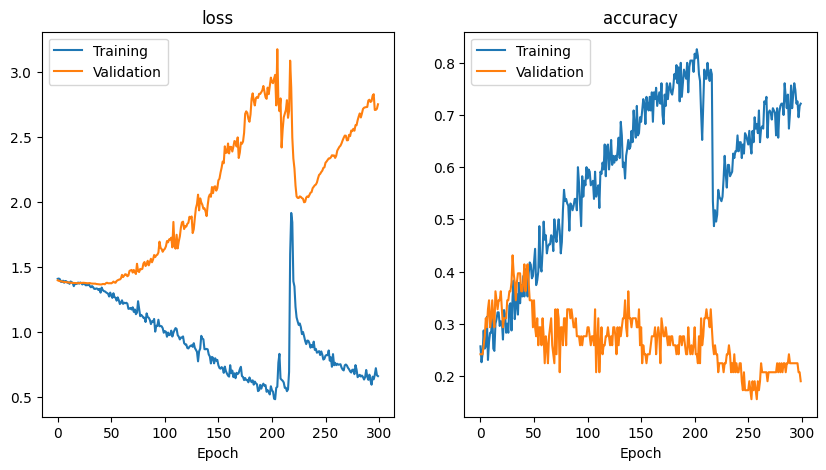

In [100]:
# Ottimizzatore
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(lstm, optimizer, dataloader_training,
                      dataloader_validation=dataloader_validation, epochs=300)

# Plot risultati del training
plot_training_metrics(metrics)

In [102]:
lstm.eval()

# Training set
encoded_train = np.zeros((0, hidden_size))
labels_train = np.zeros(0)

for batch in dataloader_training:

    x, label =  batch

    hidden_states, _ = lstm(x)
    last_hidden_state = hidden_states[:,-1,:]

    encoded_train = np.concatenate((encoded_train, last_hidden_state.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, label.cpu().detach().numpy()))

# Test set
encoded_test = np.zeros((0, hidden_size))
labels_test  = np.zeros(0)

for batch in dataloader_test:

    x, label =  batch

    hidden_states, _ = lstm(x)
    last_hidden_state = hidden_states[:,-1,:]

    encoded_test = np.concatenate((encoded_test, last_hidden_state.cpu().detach().numpy()), axis=0)
    labels_test = np.concatenate((labels_test, label.cpu().detach().numpy()))


# Addestro una SVC 
from sklearn.svm import SVC

model_svc = SVC()

# Fit del modello e calcolo accuratezza
model_svc.fit(encoded_train, labels_train)
accuracy = model_svc.score(encoded_train, labels_train)

print(f'Training accuracy = {accuracy*100:.2f}%')


accuracy = model_svc.score(encoded_test, labels_test)
print(f'Test accuracy = {accuracy*100:.2f}%')



Training accuracy = 81.74%
Test accuracy = 28.47%


### LSTM Classifier at all times
Come il caso precedente, ma il classificatore viene applicato all'hidden state a ogni istante di tempo e la loss è la somma di tutte quante. In questo modo il modello prova a predire la label a ogni istante e apprende una rappresentazione più stazionaria nel tempo

In [7]:
from models.Recurrent import LSTMClassifierAllTimes

hidden_size = 32
num_layers = 2
num_classes = 4
dropout_rate = 0.5

classifier = nn.Sequential(
    nn.Linear(hidden_size, 32),
    nn.LeakyReLU(),
    nn.Dropout(0.7),
    nn.Linear(32, num_classes)    
)

lstm = LSTMClassifierAllTimes(channels, hidden_size, num_layers, classifier, num_classes, dropout_rate)
lstm.to(device)

print(count_model_parameters(lstm))

16804


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [07:04<00:00,  4.25s/it, loss=1.36, accuracy_mean=0.271, accuracy_max=0.466]


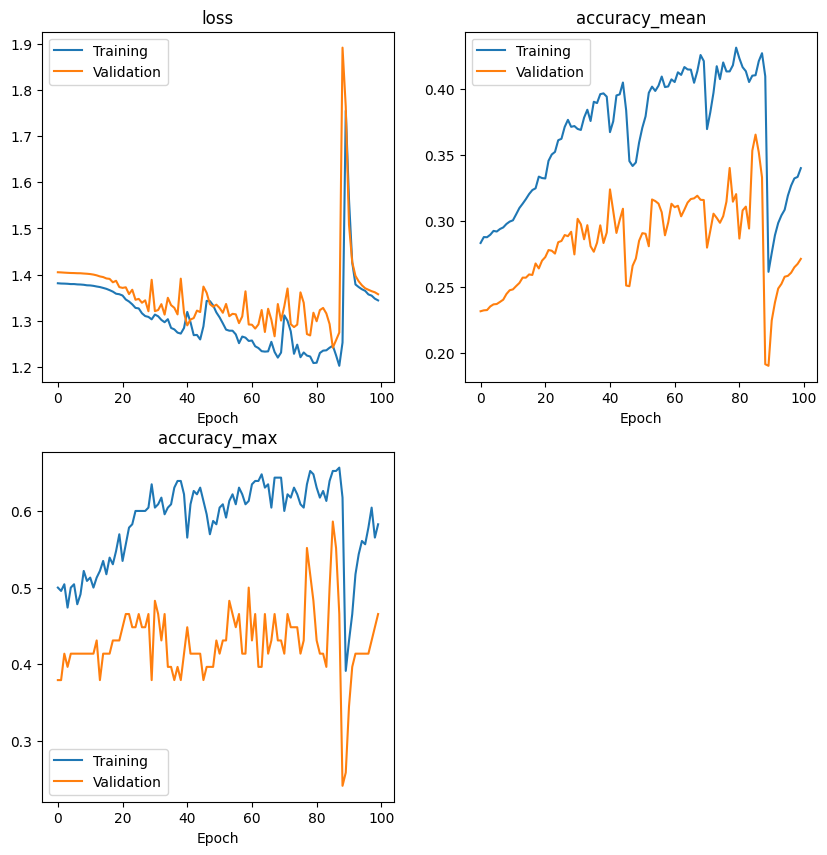

In [9]:
# Ottimizzatore
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0003)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(lstm, optimizer, dataloader_training,
                      dataloader_validation=dataloader_validation, epochs=100)

# Plot risultati del training
plot_training_metrics(metrics)

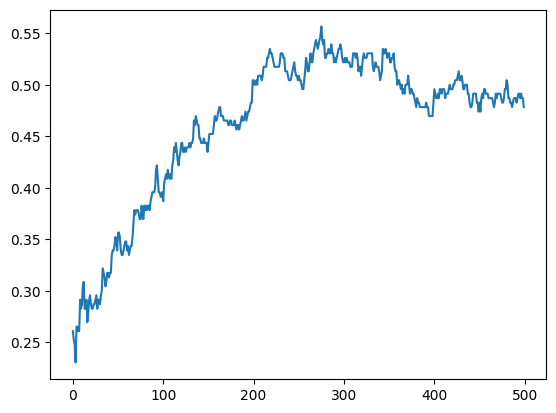

In [109]:
# Con questo modello posso vedere come cambia l'accuratezza nel tempo
lstm.eval()

accuracy = np.zeros(500)

for batch in dataloader_training:

    x, y = batch

    # Forward pass
    _, y_logits = lstm.forward(x)

    for i in range(500):
        y_pred_class = torch.argmax(torch.softmax(y_logits[:, i, :], dim=1), dim=1)
        accuracy[i] += torch.sum(y_pred_class == y)

accuracy /= len(dataset_training_pytorch)

plt.figure()
plt.plot(accuracy)



## LSTM con maschera temporale
Aggiungo una maschera (num_timepoints, 1) che può essere usata per pesare gli hidden state a istanti diversi prima che vengano sommati per ottenere l'hidden state finale

In [110]:
from models.Recurrent import LSTMClassifierTimeMask

hidden_size = 64
num_layers = 2
num_classes = 4
dropout_rate = 0.5

classifier = nn.Sequential(
    nn.Linear(hidden_size, 32),
    nn.LeakyReLU(),
    nn.Dropout(0.7),
    nn.Linear(32, num_classes)    
)

lstm = LSTMClassifierTimeMask(channels, num_timepoints, hidden_size, num_layers, classifier, dropout_rate)
lstm.to(device)

print(count_model_parameters(lstm))

58520


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:45<00:00, 11.06it/s, loss=2.25, accuracy=0.552] 


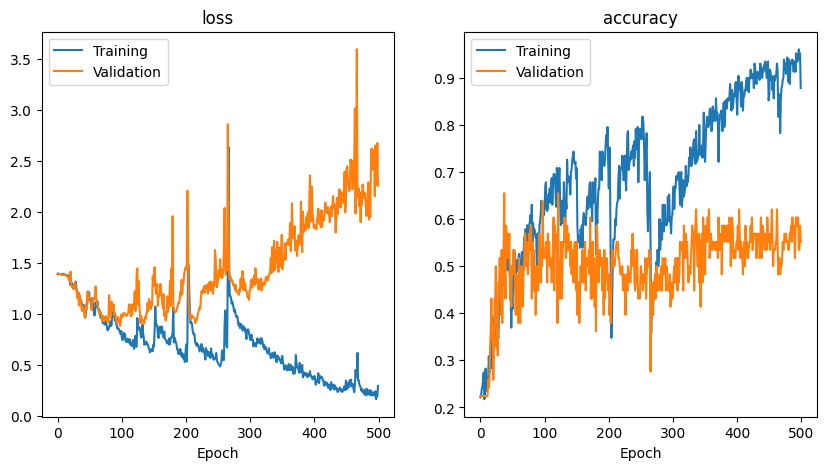

In [111]:
# Ottimizzatore
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(lstm, optimizer, dataloader_training,
                      dataloader_validation=dataloader_validation, epochs=500)

# Plot risultati del training
plot_training_metrics(metrics)

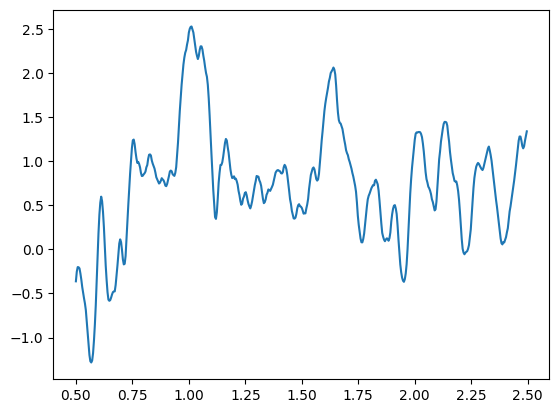

In [114]:
# Visualizzo la maschera dei tempi più significativi
lstm.eval()
plt.figure()
plt.plot(np.arange(0.5,2.5,1/250), lstm.attention_mask.squeeze().detach().cpu().numpy())

In [115]:
lstm.eval()

# Training set
encoded_train = np.zeros((0, hidden_size))
labels_train = np.zeros(0)

for batch in dataloader_training:

    x, label =  batch

    hidden_states, _ = lstm(x)
    weighted_hidden_state = torch.sum(lstm.attention_mask * hidden_states, dim=1)/torch.sum(lstm.attention_mask)

    encoded_train = np.concatenate((encoded_train, weighted_hidden_state.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, label.cpu().detach().numpy()))

# Test set
encoded_test = np.zeros((0, hidden_size))
labels_test  = np.zeros(0)

for batch in dataloader_test:

    x, label =  batch

    hidden_states, _ = lstm(x)
    weighted_hidden_state = torch.sum(lstm.attention_mask * hidden_states, dim=1)/torch.sum(lstm.attention_mask)

    encoded_test = np.concatenate((encoded_test, weighted_hidden_state.cpu().detach().numpy()), axis=0)
    labels_test = np.concatenate((labels_test, label.cpu().detach().numpy()))


# Addestro una SVC 
from sklearn.svm import SVC

model_svc = SVC()

# Fit del modello e calcolo accuratezza
model_svc.fit(encoded_train, labels_train)
accuracy = model_svc.score(encoded_train, labels_train)

print(f'Training accuracy = {accuracy*100:.2f}%')


accuracy = model_svc.score(encoded_test, labels_test)
print(f'Test accuracy = {accuracy*100:.2f}%')



Training accuracy = 95.65%
Test accuracy = 54.17%


In [180]:
from models.Recurrent import LSTMClassifierAttention

hidden_size = 256
num_layers = 1
num_classes = 4
dropout_rate = 0.5

classifier = nn.Sequential(
    nn.Linear(hidden_size, 32),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(32, num_classes)    
)

lstm = LSTMClassifierAttention(channels, num_timepoints, hidden_size, num_layers, classifier, dropout_rate)
lstm.to(device)

print(count_model_parameters(lstm))

295590


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:30<00:00,  3.33it/s, loss=3.11, accuracy=0.534]


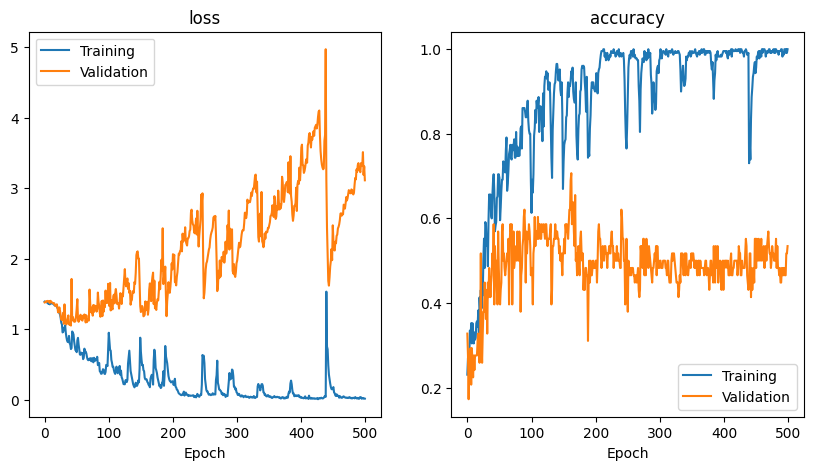

In [181]:
# Ottimizzatore
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(lstm, optimizer, dataloader_training,
                      dataloader_validation=dataloader_validation, epochs=500)

# Plot risultati del training
plot_training_metrics(metrics)

torch.Size([32, 500, 1])


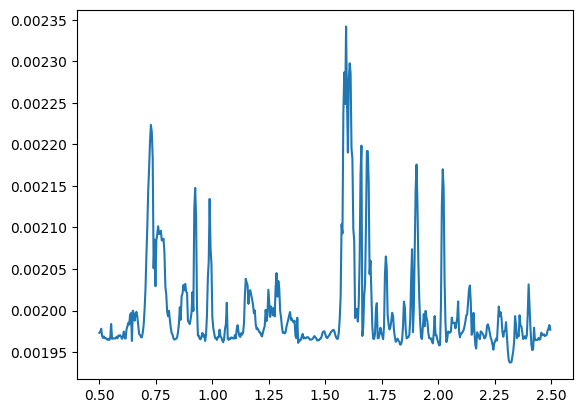

In [204]:
# Visualizzo gli attention weights per un batch di dati
lstm.eval()

for batch in dataloader_training:
    
    x, y = batch
    
    _, attention_weights, _ = lstm(x)

    print(attention_weights.shape)

    plt.figure()
    plt.plot(np.arange(0.5,2.5,1/250),attention_weights[0,:,:].detach().cpu())

    break